# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import re

from sklearn.decomposition import PCA

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [185]:
df['email'].nunique()

5148

In [186]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [187]:
print(df.shape)
df.isnull().sum()

(45993, 3)


article_id     0
title          0
email         17
dtype: int64

In [188]:
null_removed = df.isnull().sum()['email']

In [189]:
df_nonull = df.dropna(axis = 0, how = 'any')
df_nonull.shape

(45976, 3)

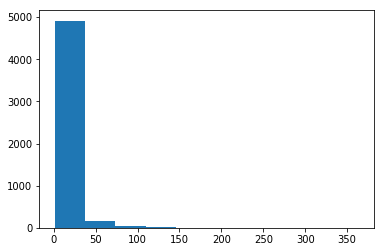

In [190]:
EDA_article = df['email'].value_counts()
plt.hist(EDA_article)
plt.show()

The majority of users interact with fewer than 10 articles.

In [191]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.percentile(EDA_article, 50) 
print('50% of individuals interact with {} number of articles or fewer.'.format(median_val))
max_views_by_user = EDA_article.max() 
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [192]:
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [193]:
# Find and explore duplicate articles
print('There are {} number of lines in the data, and {} unique articles.'.format(df_content.shape[0], 
                                                                                 df_content['article_id'].nunique()))

There are 1056 number of lines in the data, and 1051 unique articles.


In [194]:
# Remove any rows that have the same article_id - only keep the first
unique_article_id = df_content['article_id'].drop_duplicates(keep='first')
df_content_unique = df_content.loc[unique_article_id.index, :]
df_content_unique.shape

(1051, 5)

In [195]:
df_content_unique.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [196]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df_nonull['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [197]:
print('The number of unique articles that have at least one interaction: {}'.format(unique_articles)) 
print('The number of unique articles on the IBM platform: {}'.format(total_articles)) 
print('The number of unique users: {}'.format(unique_users))
print('The number of user-article interactions: {}'.format(user_article_interactions))


The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

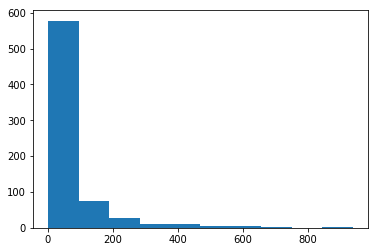

In [198]:
EDA_mostview = df['article_id'].value_counts()
plt.hist(EDA_mostview)
plt.show()

In [199]:
most_viewed_article_id = str(EDA_mostview.sort_values(ascending=False).index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = EDA_mostview.max() # The most viewed article in the dataset was viewed how many times?

In [200]:
most_viewed_article_id

'1429.0'

In [201]:
print('Most viewed article is {} with {} views'.format(most_viewed_article_id, max_views))

Most viewed article is 1429.0 with 937 views


In [202]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [203]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [204]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    df_rank = df['article_id'].value_counts().sort_values(ascending=False)
    top_articles_id = list(df_rank.index[:n])
 
    return top_articles_id # Return the top article ids

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_id = get_top_article_ids(n, df=df)
    top_articles = list(set(df[df['article_id'].isin(top_articles_id)]['title']))
    
    return top_articles # Return the top article titles from df (not df_content)

In [205]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'analyze energy consumption in buildings', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'insights from new york car accident reports', 'gosales transactions for logistic regression model', 'use deep learning for image classification', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [206]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [207]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df['article_id'] = df['article_id'].astype(str)
    user_item = df.groupby(['user_id','article_id'])['user_id'].nunique().unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [208]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [209]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_interact = np.array(user_item.loc[user_id, :])
    dot_prod_user = user_interact.dot(np.transpose(user_item))
    dot_prod_user_df = pd.DataFrame(dot_prod_user, index = user_item.index, columns = ['similarity'])
    
    # sort by similarity
    dot_prod_sort = dot_prod_user_df.sort_values(by='similarity', ascending = False)

    # create list of just the ids
    most_similar_users = list(dot_prod_sort.index)
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [210]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [211]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    idx = np.where(user_item.loc[user_id,:] == 1)
    article_ids = list(user_item.columns[idx])
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    sim_users = find_similar_users(user_id, user_item=user_item)
    user_read_id, user_read_titles = get_user_articles(user_id, user_item=user_item)
    
    recs = []
    
    for other_user in sim_users:
        if len(recs)<m:
            other_read_id, other_read_titles = get_user_articles(other_user, user_item=user_item)
            new_rec = np.setdiff1d(other_read_id, user_read_id)
            
            if len(new_rec)+len(recs) <m:
                recs.extend(new_rec)
                
            else:
                # Random articles from last paired user
                new_rec = np.random.choice(new_rec, size = m-len(recs), replace = False)
                recs.extend(new_rec)
        else:
            break
    
    return recs # return your recommendations for this user_id    

In [212]:
user_user_recs(1, 10)

['444.0',
 '682.0',
 '1172.0',
 '1101.0',
 '939.0',
 '967.0',
 '477.0',
 '1330.0',
 '1336.0',
 '1163.0']

In [213]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['higher-order logistic regression for large datasets',
 'the unit commitment problem',
 'python machine learning: scikit-learn tutorial',
 'intents & examples for ibm watson conversation',
 'data visualization playbook: telling the data story',
 'pixieapp for outlier detection',
 'easy json loading and social sharing in dsx notebooks',
 '56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object',
 'this week in data science (april 25, 2017)',
 'perform sentiment analysis with lstms, using tensorflow']

In [214]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [215]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    user_iteractions = pd.DataFrame(df.groupby(['user_id']).size(), columns = ['num_interactions'])
    
    # Rank user pair by similarity
    user_interact = np.array(user_item.loc[user_id, :])
    dot_prod_user = user_interact.dot(np.transpose(user_item))
    dot_prod_user_df = pd.DataFrame(dot_prod_user, index = user_item.index, columns = ['similarity'])
    
    # Join in interactions df
    dot_prod_user_df = dot_prod_user_df.join(user_iteractions)
    neighbors_df = dot_prod_user_df.sort_values(by=['similarity','num_interactions'], ascending = False)
    neighbors_df = neighbors_df.loc[~neighbors_df.index.isin([user_id]),:]
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item)
    user_read_id, user_read_titles = get_user_articles(user_id, user_item=user_item)
    article_rank = get_top_article_ids(len(user_item.columns), df=df)
    
    recs = []
    
    for other_user in neighbors_df.index:
        if len(recs)<m:
            other_read_id, other_read_titles = get_user_articles(other_user, user_item=user_item)
            new_rec = np.setdiff1d(other_read_id, user_read_id)
            
            if len(new_rec)+len(recs) <m:
                recs.extend(new_rec)
                
            else:
                new_rec_rank = [article_rank.index(i) for i in new_rec]
                new_rec_df = pd.DataFrame({'rank': new_rec_rank}, index=new_rec).sort_values(by='rank')
                new_rec = list(new_rec_df.index[:m-len(recs)])
                recs.extend(new_rec)
        else:
            break    
      
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [216]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['analyze energy consumption in buildings', 'putting a human face on machine learning', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'insights from new york car accident reports', 'gosales transactions for logistic regression model', 'analyze accident reports on amazon emr spark', 'model bike sharing data with spss', 'movie recommender system with spark machine learning', 'use xgboost, scikit-learn & ibm watson machine learning apis']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [217]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).index[0]
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).index[9]

In [218]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

I would use rank-based recommendation functions - get_top_article_ids and get_top_articles. Given that they are popular with the general user base, they are likelier to be viewed by the new user.

As there is no prior records of what the new user likes or has interacted with before, it would be impossible find similar users based on user history. Collaborative filtering would not be a viable option.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [219]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df=df)# Your recommendations here

print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [220]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [221]:
# Download punkt and stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [222]:
df_content['doc_status'].unique()

array(['Live'], dtype=object)

The doc_status column can be ignored in analysis since it is the same across all articles.

In [223]:
# Impute Nulls with blank
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [224]:
df_content['doc_description'] = df_content['doc_description'].fillna("")

In [225]:
# Create a column combining title and description 
# Will not use body text for anlaysis

df_content['title_desc'] = df_content['doc_full_name'] + ' ' + df_content['doc_description']
df_content['title_desc'][0]

'Detect Malfunctioning IoT Sensors with Streaming Analytics Detect bad readings in real time using Python and Streaming Analytics.'

In [226]:
def text_processing(text):
    '''
    Tokenize by word, remove stop words, lemmatize all phrases in the dataframe
    
    INPUT:
    text
    
    OUTPUT:
    df - df with three new columns: one normalised, one tokenized, another with stop words removed in addition, and the
    last one lemmatized in addition to previous steps
    '''

    new_text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    new_text = word_tokenize(new_text)

    sw_list = stopwords.words("english")
    new_text = [w for w in new_text if w not in sw_list]

    for postag in ['a','s','r','n','v']:
        new_text = [WordNetLemmatizer().lemmatize(w, pos = postag) for w in new_text]        
    
    return new_text

In [227]:
def tfidf_vect(df, col_name, tokenizer=text_processing):
    '''
    Tfidf transform a column
    OUTPUT:
    output_X - df with vocab as column title and the corresponding array in df
    vect - initialised count vectorizer
    transformer - initialised tfidf transformer
    '''
    
    # 1- CountVectorize col
    vect = CountVectorizer(tokenizer=text_processing)
    X = vect.fit_transform(df[col_name])
    vocab_name = list(pd.Series(vect.vocabulary_).sort_values().index)
    
    # 2- Tfidf Transform  
    transformer = TfidfTransformer(smooth_idf=False)
    X_tfidf = transformer.fit_transform(X)
    
    output_X = pd.DataFrame(X_tfidf.toarray(), columns = vocab_name)
    
    return output_X, vect, transformer

df_tfidf, cv_vect, tfidf_trans = tfidf_vect(df_content, 'title_desc')
df_tfidf.head()

,0,00,01,02,03,05,06,08,09,1,...,yolo,york,young,youtube,yu,zachary,zapier,zendesk,zero,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.24207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
# As there are too many features and that the matrix is sparse, It wil 

pca_test = PCA(n_components= df_tfidf.shape[1])
tfidf_pca = pca_test.fit_transform(df_tfidf.values)
pca_var = pca_test.explained_variance_ratio_
pca_cumvar = np.cumsum(pca_var)

Text(0.5,1,'Explained/Cumulative Variance Per Principal Component')

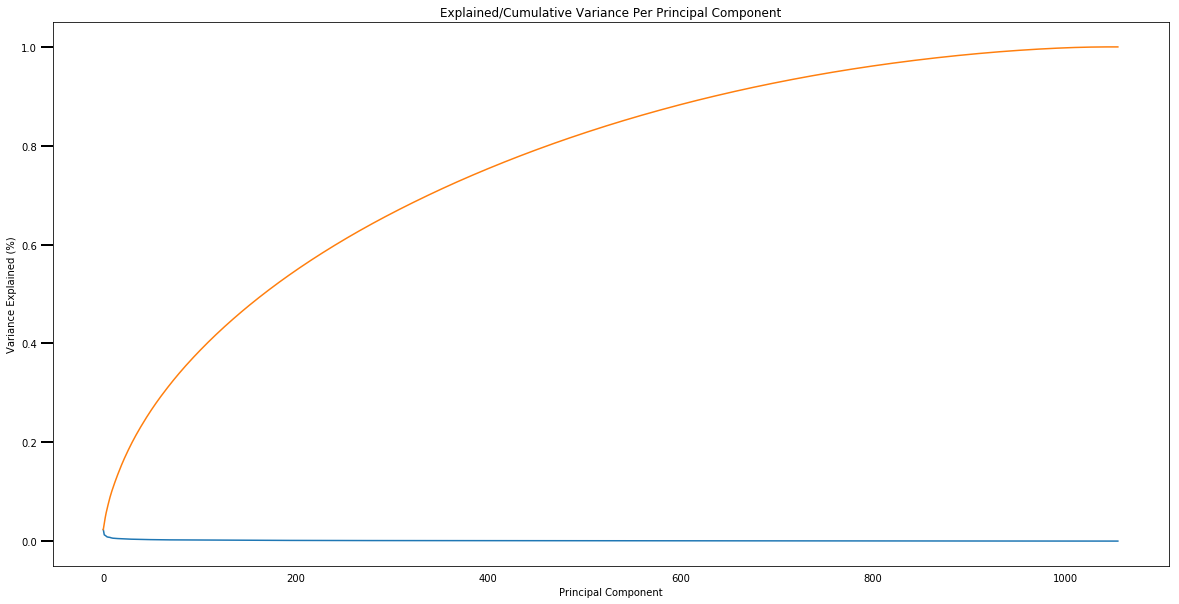

In [229]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

ax.plot(np.arange(pca_var.shape[0]), pca_var)
ax.plot(np.arange(pca_var.shape[0]), pca_cumvar)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained/Cumulative Variance Per Principal Component')

From the above matrix and the chart, we can see that 600 principal components can already explain 90% of the total variance. It is because the variety of vocabulary is high and the matrix is sparse. As there are a lots of keywords (e.g. numbers) that might be less relevant, some of them might be noise. Therefore, it is likely sufficient to take 400 components which would explain around 60% of variance.

In [230]:
def pca_trans(df, n_comp):
    
    pca_test = PCA(n_components=n_comp)
    tfidf_pca = pca_test.fit_transform(df.values)
    tfidf_df = pd.DataFrame(tfidf_pca, index = df.index)

    return tfidf_df

In [231]:
n_comp = 400
df_pca = pca_trans(df_tfidf, n_comp)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.055724,0.066103,-0.018785,-0.033082,-0.001543,-0.084620,-0.070344,-0.025958,0.054362,-0.050347,...,-0.001143,0.010577,-0.013370,-0.046263,0.017050,0.069716,-0.018200,-0.013687,0.007806,0.001812
1,0.051917,0.084684,0.092168,0.010935,-0.059101,0.021036,0.000943,0.103167,-0.005255,0.030799,...,-0.039863,0.018099,-0.033576,0.002527,0.015027,-0.007485,0.037577,-0.044879,0.033397,0.016767
2,0.706632,-0.071965,0.009816,0.074500,0.080827,0.051251,-0.015797,0.000366,0.041794,0.074361,...,0.008819,0.034395,-0.023620,-0.012821,0.018034,-0.017897,0.029240,-0.037581,0.011594,0.015458
3,-0.035511,-0.018591,0.074605,0.012588,-0.009843,0.015325,-0.006216,0.029955,-0.051160,0.011796,...,-0.002528,-0.001512,-0.029326,-0.024839,-0.039691,0.015417,0.038140,-0.005592,-0.000468,-0.018648
4,0.005199,0.125249,-0.086444,-0.068136,0.034625,-0.040645,0.124070,-0.030853,-0.059938,-0.081607,...,-0.015046,-0.027513,-0.025903,-0.057375,0.015630,-0.002631,0.037232,-0.008590,0.008041,-0.024768


In [234]:
def find_similar_articles(art_id, df):
    '''
    INPUT:
    art_id - (int) an article_id
    df - (pandas dataframe) matrix of articles by content features
    
    OUTPUT:
    similar_arts - (list) an ordered list where the most similar articles are returned
    
    Description:
    Computes the similarity of every pair of articles based on the dot product
    
    '''
    # compute similarity of each user to the provided user
    art_feat = np.array(df.loc[art_id, :])
    dot_prod_art = art_feat.dot(np.transpose(df))
    dot_prod_art_df = pd.DataFrame(dot_prod_art, index = df.index, columns = ['similarity'])
    
    # filter for only max similarity
    dot_prod_sort = dot_prod_art_df.sort_values(by='similarity', ascending = False)

    # create list of just the ids
    most_similar_arts = list(dot_prod_sort.index)
   
    # remove the own user's id
    most_similar_arts.remove(art_id)
       
    return most_similar_arts # return a list of the articles in order from most to least similar

In [235]:
def make_content_recs(_id, id_type = 'user', n_rec = 5, df_con = df_pca):
    '''
    Recommend articles similar to the ones that the user has read if user_id is given, or similar to the article,
    if article id is given
    
    INPUT:
    _id - article or user id
    id_type - indicates whether the id is an article or a user id, select either 'user' or 'article', default is user
    n_rec - number of recommendations given
    
    OUTPUT:
    art_id - 
    art_name -
    '''
    rec_id = []
    rec_names = []
    
    # If user id is given, select an article from the read articles list, and find the top three similar articles
    if (id_type == 'user') and (_id in user_item.index):
        art_read_id, art_read = get_user_articles(_id, user_item=user_item)
        
        for art_id in random.sample(art_read_id, len(art_read_id)):
            if (len(rec_id)<= n_rec) and (int(float(art_id)) in df_con.index):
                most_similar_arts = find_similar_articles(int(float(art_id)), df_con)[:3]
                rec_id.extend([i for i in most_similar_arts if i not in rec_id])
            else:
                pass
            
        rec_id = rec_id[:n_rec]
        rec_names = list(set(df_content[df_content['article_id'].isin(rec_id)]['doc_full_name']))
        
    elif (id_type == 'article') and (_id in df_con.index):
        most_similar_arts = find_similar_articles(int(_id), df_con)[:n_rec]
        rec_id.extend(most_similar_arts)
        
        rec_id = rec_id[:n_rec]
        rec_names = list(set(df_content[df_content['article_id'].isin(rec_id)]['doc_full_name']))
        
    # if new user or article id given, recommend most popular articles and 
    else:
        top_id = get_top_article_ids(int(n_rec*2), df=df)
        
        for art_id in top_id:
            rec_id.append(art_id)
            if (len(rec_id)<= n_rec) and (art_id in df_con.index):
                most_similar_arts = find_similar_articles(art_id, df_con)[0]
                rec_id.extend(most_similar_arts)
                rec_id = list(set(rec_id))
            else:
                pass
            
        rec_id = rec_id[:n_rec]
        rec_names = get_article_names(rec_id)       

    return rec_id, rec_names    

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Content based recommendation will list out articles similar to the ones read by the indicated user, or the indicated article. If a new user or article is passed into the system, it will recommend the most popular articles and the most similar article associated with each.**

**The advantage of using content based recommendation system is that it could recommend articles that are new or not as popular. However this method is likely to recommend relevant and novel content, rather than helping users discover new categories or contents. This particular code couldn't provide recommendations of new items as they are not listed in the df_content.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [236]:
# recommendation for user #1
make_content_recs(1, id_type = 'user', n_rec = 5, df_con = df_pca)

([889, 359, 446, 83, 811],
 ["Compose's first graph database: JanusGraph",
  'What’s New in Data Refinery?',
  'Getting the distance using Redis and PostgreSQL',
  'Optimizing a marketing campaign: Moving from predictions to actions',
  'Mobile App Webinar Demo'])

In [237]:
# recommendation for user #100
make_content_recs(100, id_type = 'article', n_rec = 5, df_con = df_pca)

([830, 530, 654, 809, 1027],
 ['Use the Machine Learning Library',
  'MongoDB and Ransomware',
  'What You Need to Know to Extend NiFi',
  'Getting Started with Elasticsearch using Compose',
  'Blazingly Fast Geospatial Queries with Redis'])

In [238]:
# make a recommendations for a user who only has interacted with article id '1427.0'

test_conrec_id, test_conrec_names = make_content_recs('1427.0', id_type = 'article', n_rec = 5, df_con = df_pca)
print(test_conrec_id, test_conrec_names)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0'] ['predicting churn with the spss random tree algorithm', 'insights from new york car accident reports', 'use deep learning for image classification', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis']


In [239]:
# make recommendations for a brand new user

make_content_recs(10000, id_type = 'user', n_rec = 5, df_con = df_pca)

(['1429.0', '1330.0', '1431.0', '1427.0', '1364.0'],
 ['predicting churn with the spss random tree algorithm',
  'insights from new york car accident reports',
  'use deep learning for image classification',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [240]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [241]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [242]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**In the lesson, FunkSVD is used to impute a sparse matrix with a lot of nulls. Gradient descent is used to estimate matrices U and VT that would minimise the error of their dot product and the actual sparse user-item matrix of ratings. The resulting matrix is the predicted rating of each user for each article. In this way, recommendations can still be provided to users with little activities on the site.**

**In this case, there is no nulls in the user-item matrix and so FunkSVD is not required. However, number of latent features can still be optimised such that more relevant articles can be recommended to users in the future (i.e. minimising error against test matrix).**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

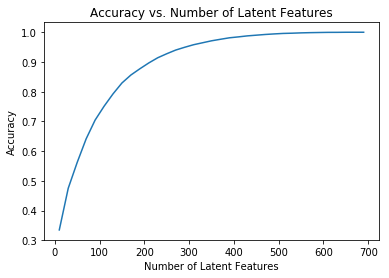

In [243]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [244]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [245]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create user item matrices for train and test data separately
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
      
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [246]:
print(len(test_idx), len(test_arts))

682 574


In [247]:
# Number of users that exist in both datasets
print(len(set(test_idx).intersection(set(user_item_train.index))))

# Number of articles that exist in both datasets
print(len(set(test_arts).intersection(set(user_item_train.columns))))

20
574


In [248]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,  
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,  
    'How many movies can we make predictions for in the test set?': b, 
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [249]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) 

In [250]:
# List of users common between train and test sets whose predictions can be compared on
test_id = list(set(test_idx).intersection(set(user_item_train.index)))
test_id_loc = [list(user_item_train.index).index(i) for i in test_id] #its relative position in array

# List of articles common between train and test sets whose predictions can be compared on
test_art = list(set(test_arts).intersection(set(user_item_train.columns)))
test_art_loc = [list(user_item_train.columns).index(i) for i in test_art]

In [251]:
user_item_act_train = user_item_train.loc[test_id, test_art]
user_item_act_test = user_item_test.loc[test_id, test_art]
user_item_act_all = user_item_matrix.loc[test_id, test_art]

num_latent_feats = np.arange(10,700+10,20)
train_errs = []
test_errs = []
all_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[test_id_loc, :k], vt_train[:k, test_art_loc]
    user_item_est_train = np.around(np.dot(np.dot(u_new, s_new), vt_new))    

    # compute error for each prediction to actual value
    train_diffs = np.subtract(user_item_act_train, user_item_est_train)
    test_diffs = np.subtract(user_item_act_test, user_item_est_train)
    all_diffs = np.subtract(user_item_act_all, user_item_est_train)

    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(train_diffs)))
    train_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    test_errs.append(test_err)
    
    all_err = np.sum(np.sum(np.abs(all_diffs)))
    all_errs.append(all_err)

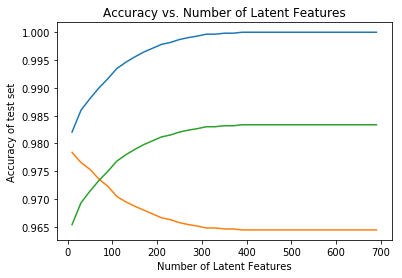

In [252]:
plt.plot(np.arange(10,700+10,20), 1-(np.array(train_errs)/(user_item_act_test.shape[0]* user_item_act_test.shape[1])));
plt.plot(np.arange(10,700+10,20), 1-(np.array(test_errs)/(user_item_act_test.shape[0]* user_item_act_test.shape[1])));
plt.plot(np.arange(10,700+10,20), 1-(np.array(all_errs)/(user_item_act_test.shape[0]* user_item_act_test.shape[1])));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy of test set');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**As opposed to the rising accuracy of trained data prediction as the number of latent features increases, accuracy of test data prediction decreases. Nevertheless, the overall accuracy is still very high at >95%. **

**One particular reason could be the sparsity of data. The test set only has 20 users but there are more than 500 articles. Most values are zero. A solution would be to train the algorithm on shuffled train and test data multiple times and take the mean of results. Another would be to add dimension to the data to indicate degree of user-article interaction, e.g. number of times read, whether the user saved, commented or shared the article, if the data exists. It would better indicate the level of interest the user has towards particular types of articles and more relevant latent features could be derived.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [253]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0